In [1]:
import lightkurve as lk
import numpy as np
import pandas as pd
import glob
from astropy.io import ascii
from astropy.table import Table, join
from astropy.io import fits
import matplotlib.pyplot as plt
import lightkurve as lk
import starspot as ss
from starspot import sigma_clipping

# load useful data

In [24]:
mq = pd.read_csv('data/mcquillan_sample.csv') #mq data for comparisons
allstats = ascii.read('data/bigstats_stitchedlcs.fits')#all acf/ls for all tics
pdm = np.load('data/FOURTHRUN/pdm.npy')
pdm_err = np.load('data/FOURTHRUN/pdm_err.npy')
pdm_tics = np.load('data/FOURTHRUN/tic_order_pdm.npy')

print('note to self: change that mq sample b/c this is the one i gave to Marta')

note to self: change that mq sample b/c this is the one i gave to Marta


# Pull stats out from plots - forgot to do in .py script

In [3]:

tics = np.load('data/all_dled_tics.npy') 
ls_rps = {};acf_rps={}
for count,tic in enumerate(tics):
    try:
        acf_x = np.load('data/FOURTHRUN/data_arrs/{}/acf_lags.npy'.format(tic))
        acf_y = np.load('data/FOURTHRUN/data_arrs/{}/acf_ys.npy'.format(tic))
        ls_x = np.load('data/FOURTHRUN/data_arrs/{}/ls_freq.npy'.format(tic))
        ls_y = np.load('data/FOURTHRUN/data_arrs/{}/ls_power.npy'.format(tic))
        #ls rps
        ps = 1./ls_x
        peaks = np.array([i for i in range(1, len(ps)-1) if ls_y[i-1] < \
                    ls_y[i] and ls_y[i+1] < ls_y[i]])
        peak_amps_low2high = np.sort(ls_y[peaks])
        ls_rp1 = ps[ls_y == peak_amps_low2high[-1]][0] # note that is is only correct to 2 dec places compared to value on plots 
        ls_rp2 = ps[ls_y == peak_amps_low2high[-2]][0]
        ls_rp3 = ps[ls_y == peak_amps_low2high[-3]][0]
        ls_rps[tic] = [ls_rp1,ls_rp2,ls_rp3]
        #acf rps
        peaks2 = np.array([i for i in range(1,len(acf_y)-1) if acf_y[i-1] < acf_y[i] and \
                         acf_y[i+1] <acf_y[i]])
        x_peaks = acf_x[peaks2]
        y_peaks = acf_y[peaks2]
        inds = np.argsort(y_peaks)
        xpeaks = x_peaks[inds][::-1]
        acf_rp = xpeaks[0]
        if len(xpeaks) >= 2:
            acfrp2 = xpeaks[1]
        else:
            acfrp2 = acf_rp
        if len(xpeaks) >= 3:
            acfrp3 = xpeaks[2]
        else:
            acfrp3 = acf_rp
        acf_rps[tic] = [acf_rp,acfrp2,acfrp3]
    except FileNotFoundError:
        print('stopped at count {},tic: {} for error '.format(count,tic))
        break
#     print('TIC:',tic,'ACF RPs:',acf_rp,acfrp2,acfrp3)
## plots to verify hitting peaks
#     plt.plot(-np.log10(ls_x),ls_y)
#     plt.axvline(np.log10(ls_rp1),color='orange')
#     plt.axvline(np.log10(ls_rp2),ls='--', color='cyan')
#     plt.axvline(np.log10(ls_rp3),color='g',ls='-.')
#     plt.title('TIC: {}'.format(tic))
#     print('TIC:',tic, 'LS RPs:',ls_rp1,ls_rp2,ls_rp3)


stopped at count 2340,tic: 177312538 for error 


In [4]:
# group rps by peak order
#ls
ls_ones = [ls_rps[key][0] for key in list(ls_rps.keys())]
ls_twos = [ls_rps[key][1] for key in list(ls_rps.keys())]
ls_threes = [ls_rps[key][2] for key in list(ls_rps.keys())]
tic_order = list(ls_rps.keys())
#acf
acf_ones = [acf_rps[key][0] for key in list(acf_rps.keys())]
acf_twos = [acf_rps[key][1] for key in list(acf_rps.keys())]
acf_threes = [acf_rps[key][2] for key in list(acf_rps.keys())]
acf_tic_order = list(acf_rps.keys())

In [5]:
#sanity check

print('make sure LS are all the same:',len(ls_ones),len(ls_twos),len(ls_threes),len(tic_order))
print('make sure ACF are all the same:',len(acf_ones),len(acf_twos),len(acf_threes),len(acf_tic_order))

make sure these are all the same: 2340 2340 2340 2340
make sure these are all the same: 2340 2340 2340 2340


# Look at results (rps)

In [40]:
# match tics to allstats to get temps

## ACF/LS
matching_indices =[]
temps = []
for tic in tic_order:
    idx = np.where(allstats['ID']== tic)
    matching_indices.append(idx)
    temps.append(allstats[idx]['Teff'])
print(len(matching_indices),'==',len(tic_order), 'OR else some ls/acf are missing from allstats')
## PDM
pdm_matching_indices =[]
pdm_temps = []
for tic in pdm_tics:
    idx = np.where(allstats['ID']== tic)
    pdm_matching_indices.append(idx)
    pdm_temps.append(allstats[idx]['Teff'])
print(len(pdm_matching_indices),'==',len(pdm_tics), 'OR else some pdm are missing from allstats')



2340 == 2340 OR else some ls/acf are missing from allstats
2359 == 2359 OR else some pdm are missing from allstats


/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  del sys.path[0]


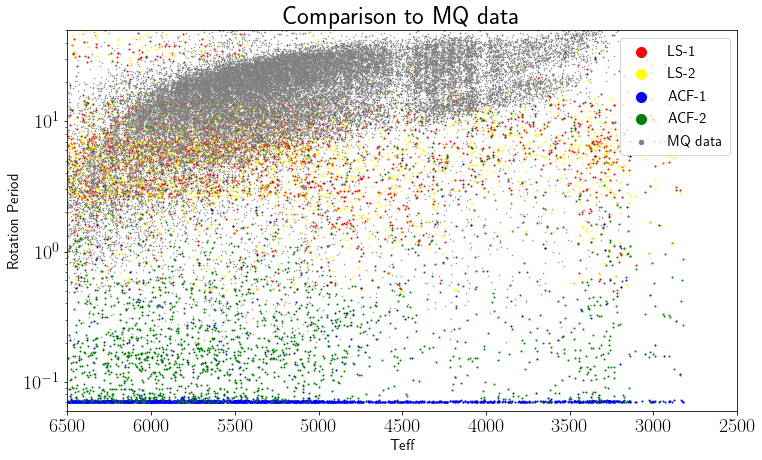

In [63]:
plt.figure(figsize=(12,7))
plt.scatter(temps,ls_ones,s=1,color='r',label='LS-1')
plt.scatter(temps,ls_twos,s=1,color='yellow',label='LS-2')
plt.scatter(temps,acf_ones,s=1,color='b',label='ACF-1')
plt.scatter(temps,acf_twos,s=1,color='g',label='ACF-2')
plt.scatter(mq['TEMP'],mq['ROTATION_PERIOD'],s=.2,color='grey',label='MQ data')
plt.legend(markerscale=10., scatterpoints=1,fontsize=15)
plt.title('Comparison to MQ data',fontsize=25)
plt.ylabel('Rotation Period',fontsize=15)
plt.xlabel('Teff',fontsize=15)
plt.yscale('log')
plt.xlim(6500,2500)
plt.ylim(0,50);

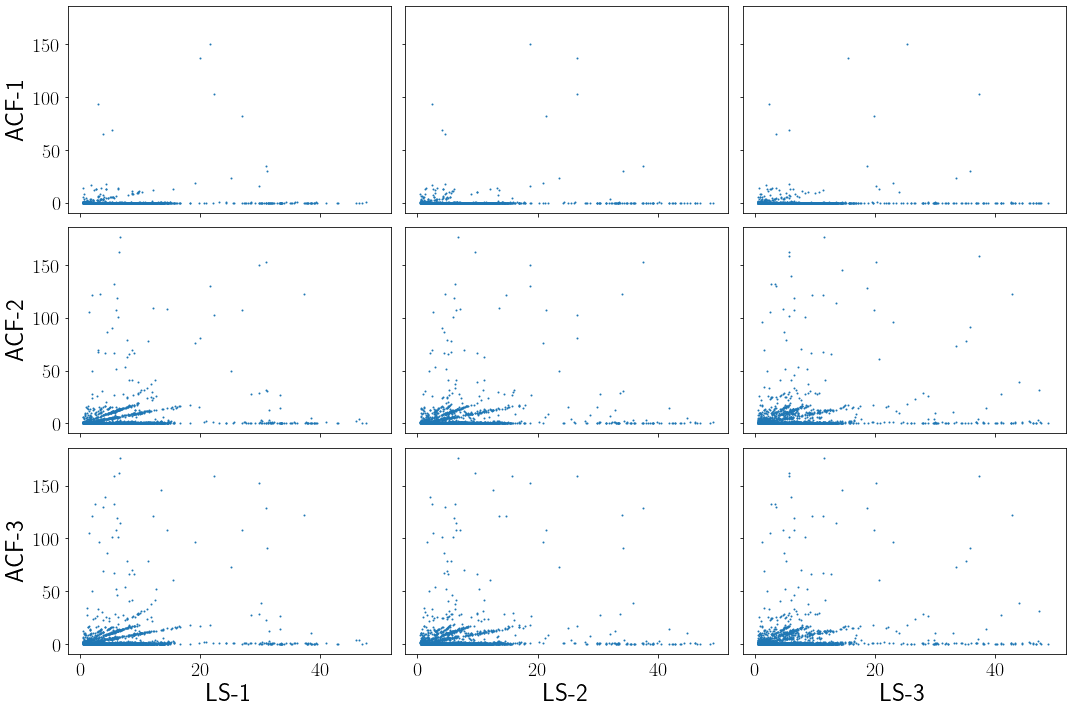

In [33]:
# comparing to each other

f, ax = plt.subplots(3,3, figsize=(15,10),sharey =True,sharex=True)
ax[0,0].scatter(ls_ones,acf_ones, s=1)
ax[0,0].set_ylabel('ACF-1')
ax[0,1].scatter(ls_twos,acf_ones, s=1)
ax[0,2].scatter(ls_threes,acf_ones, s=1)

ax[1,0].scatter(ls_ones,acf_twos, s=1)
ax[1,0].set_ylabel('ACF-2')
ax[1,1].scatter(ls_twos,acf_twos, s=1)
ax[1,2].scatter(ls_threes,acf_threes, s=1)

ax[2,0].scatter(ls_ones,acf_threes, s=1)
ax[2,0].set_ylabel('ACF-3')
ax[2,0].set_xlabel('LS-1')
ax[2,1].scatter(ls_twos,acf_threes, s=1)
ax[2,1].set_xlabel('LS-2')
ax[2,2].scatter(ls_threes,acf_threes, s=1)
ax[2,2].set_xlabel('LS-3')

plt.tight_layout()

dont forget set a limit on PDM of 15 day periods to speed up and account for prob with getting >15
12 out of 2359 periods == 15 day limit
312 out of 2359 periods between 14-15 days


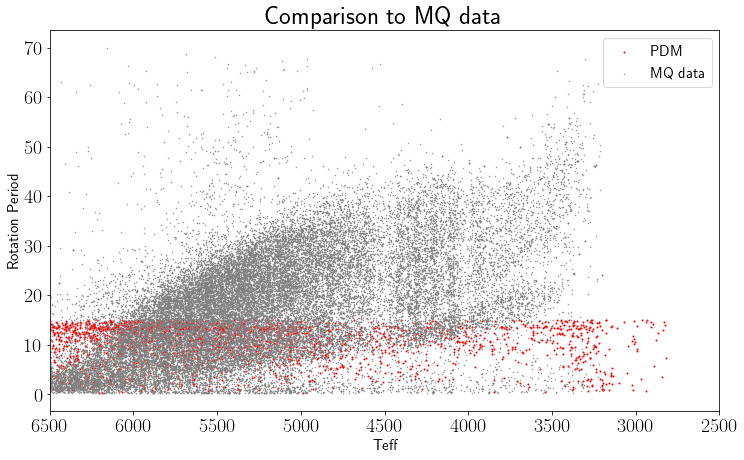

In [58]:
plt.figure(figsize=(12,7))
plt.scatter(pdm_temps,pdm,s=1,color='r',label='PDM')##### pdm[0:len(temps)] to match temps len--n/m just got pdm_temps instead
plt.scatter(mq['TEMP'],mq['ROTATION_PERIOD'],s=.2,color='grey',label='MQ data')
plt.legend(fontsize=15)
plt.title('Comparison to MQ data',fontsize=25)
plt.ylabel('Rotation Period',fontsize=15)
plt.xlabel('Teff',fontsize=15)
plt.xlim(6500,2500);
print('dont forget set a limit on PDM of 15 day periods to speed up and account for prob with getting >15')
print('{} out of {} periods == 15 day limit'.format(len(pdm[pdm==15]),len(pdm)))
print('{} out of {} periods between 14-15 days'.format(len(pdm[pdm>=14.]),len(pdm)))